# Portfolio Balancing and Optimization

In this section, we will discuss about portfolio balancing and optimization using pyfolio and numpy serialization.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

[*********************100%***********************]  5 of 5 completed


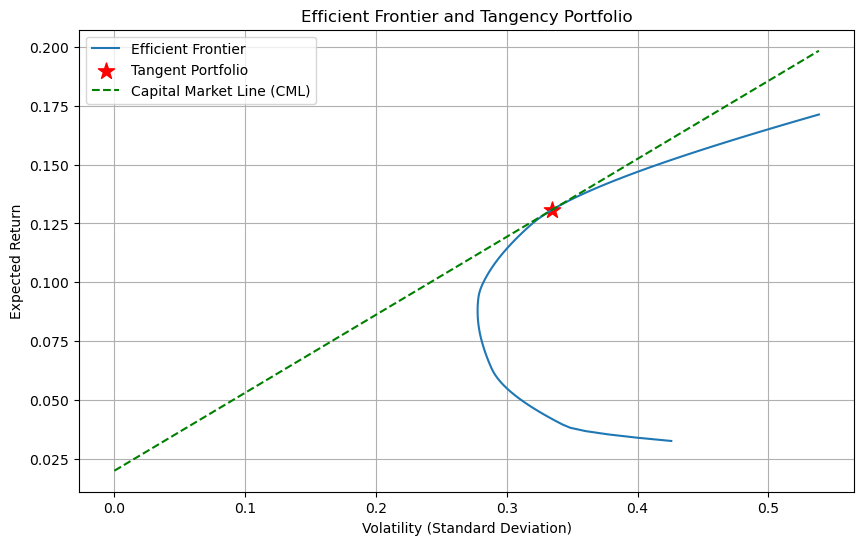

📌 Tangent Portfolio 비중 (샤프비율 최대):
AAPL: 0.00%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 28.18%
META: 71.82%

📈 기대 수익률: 13.07%
📉 기대 변동성: 33.44%
⚖️ 샤프 비율: 0.33


In [ ]:
# 1. 데이터 불러오기
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start="2022-01-01", end="2024-01-01", auto_adjust=True)['Close']
returns = data.pct_change().dropna()

mu = returns.mean() * 252
cov = returns.cov() * 252
n = len(tickers)

# 2. 효율적 투자선 생성
def get_portfolio_stats(weights):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return port_return, port_vol

def minimize_volatility(target_return):
    # 목적함수: 변동성 최소화
    def portfolio_volatility(weights):
        return get_portfolio_stats(weights)[1]

    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mu) - target_return}
    )
    bounds = [(0, 1) for _ in range(n)]
    result = minimize(portfolio_volatility, x0=np.ones(n)/n,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# 3. 효율선 위의 포인트 계산
target_returns = np.linspace(mu.min(), mu.max(), 100)
efficient_returns = []
efficient_vols = []

for r in target_returns:
    w = minimize_volatility(r)
    ret, vol = get_portfolio_stats(w)
    efficient_returns.append(ret)
    efficient_vols.append(vol)

# 4. 샤프 비율 최대 포트폴리오 (== CML 접점)
rf = 0.02
def neg_sharpe(w):
    r, v = get_portfolio_stats(w)
    return -(r - rf) / v

cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * n
res = minimize(neg_sharpe, x0=np.ones(n)/n, method='SLSQP', bounds=bounds, constraints=cons)
tangent_w = res.x
tangent_ret, tangent_vol = get_portfolio_stats(tangent_w)
tangent_sharpe = (tangent_ret - rf) / tangent_vol

# 5. 시각화
plt.figure(figsize=(10,6))
plt.plot(efficient_vols, efficient_returns, label="Efficient Frontier")
plt.scatter(tangent_vol, tangent_ret, c='red', marker='*', s=150, label='Tangent Portfolio')

# Capital Market Line (CML)
cml_x = np.linspace(0, max(efficient_vols), 100)
cml_y = rf + tangent_sharpe * cml_x
plt.plot(cml_x, cml_y, 'g--', label='Capital Market Line (CML)')

plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Tangency Portfolio')
plt.legend()
plt.grid(True)
plt.show()

# 6. 출력
print(" Tangent Portfolio 비중 (샤프비율 최대):")
for i in range(n):
    print(f"{tickers[i]}: {tangent_w[i]*100:.2f}%")
print(f"\n 기대 수익률: {tangent_ret:.2%}")
print(f"기대 변동성: {tangent_vol:.2%}")
print(f"샤프비: {tangent_sharpe:.2f}")

[*********************100%***********************]  5 of 5 completed

🎯 최소분산 조건 하에서 최대 수익률 포트폴리오:
AAPL: 30.00%
MSFT: 10.00%
GOOGL: 30.00%
AMZN: 0.00%
META: 30.00%

📈 기대 수익률: 7.32%
📉 기대 변동성: 28.95% (제한: 27.77%)



/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(b

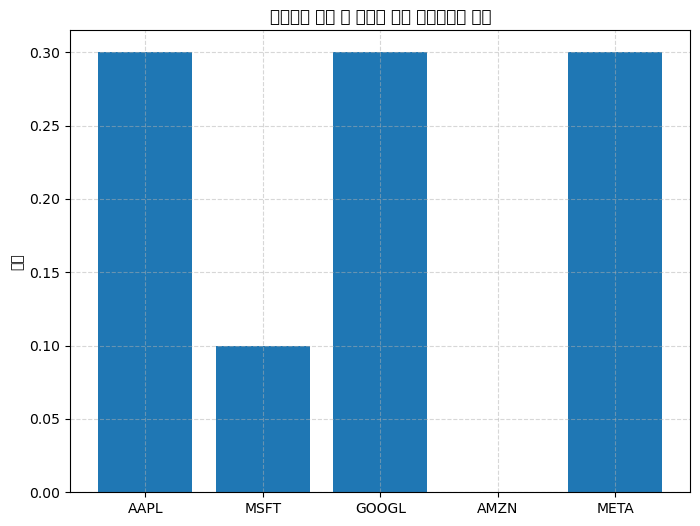

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data = yf.download(tickers, start="2022-01-01", end="2024-01-01", auto_adjust=True)['Close']
returns = data.pct_change().dropna()

mu = returns.mean() * 252
cov = returns.cov() * 252
n = len(tickers)

# 2. 최소분산 포트폴리오 계산 (vol을 최소화)
def portfolio_volatility(w):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

def min_variance_portfolio():
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(n)]
    result = minimize(portfolio_volatility, x0=np.ones(n)/n,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

w_minvar = min_variance_portfolio()
minvar_vol = portfolio_volatility(w_minvar)

# 3. 제한된 변동성 아래에서 수익률 최대화
def negative_return(w):
    return -np.dot(w, mu)  # maximize return

constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq', 'fun': lambda w: minvar_vol - portfolio_volatility(w)}  # 변동성 ≤ 최소분산포트폴리오 수준
]
bounds = [(0, 0.3)] * n
res = minimize(negative_return, x0=np.ones(n)/n, method='SLSQP',
               bounds=bounds, constraints=constraints)

w_opt = res.x
opt_ret = np.dot(w_opt, mu)
opt_vol = portfolio_volatility(w_opt)

# 4. 결과 출력
print("최소분산 조건 하에서 최대 수익률 포트폴리오:")
for i in range(n):
    print(f"{tickers[i]}: {w_opt[i]*100:.2f}%")
print(f"\n📈 기대 수익률: {opt_ret:.2%}")
print(f"📉 기대 변동성: {opt_vol:.2%} (제한: {minvar_vol:.2%})")

# 5. 시각화
plt.figure(figsize=(8,6))
plt.bar(tickers, w_opt)
plt.title("최소분산 제한 하 수익률 최대 포트폴리오 비중")
plt.ylabel("비중")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()